In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import gym
import numpy as np
from collections import deque
import time
import tqdm
import pybullet_envs


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
class DDPG():
    
    def __init__(self, env_name, gamma = 0.9, replay_buffer_size = 10000, learning_rate = 0.0003,\
                batch_size = 32):
        self._env = gym.make(env_name)
        self._evaluation_env = gym.make(env_name)
        self._gamma = gamma
        self._batch_size = batch_size
        self._learning_rate = learning_rate
        self._replay_buffer_size = replay_buffer_size
        self._graph = {}
        self._obs_dim = self._env.observation_space.shape[0]
        self._n_acts = self._env.action_space.shape[0]
        self._evaluation_scores = []
        self._finished_episodes = 0
        self._build_computational_graph_continuous_actions()

    def train(self, n_steps = 10**6):
        self._fill_replay_buffer()
        continue_training = True
        for i in tqdm.tqdm_notebook(range(n_steps)):
            state, action, reward, new_state, done = self._sample_experience()
            self._add_sample_to_replay_buffer(state, action, reward, new_state, done)
            self._update_q_function()
            if i % 1000 == 0:
                self._evaluate_model(5)
                self._update_target_networks_hard()
        return self._evaluation_scores
    
#     def _update_target_networks_soft(self):
#         self._sess.run([v_t.assign(0.05*v+0.95*v_t) for v_t, v in \
#                 zip(self._graph['actor_target'].trainable_weights,\
#                     self._graph['actor_network'].trainable_weights)])
#         self._sess.run([v_t.assign(0.05*v+0.95*v_t) for v_t, v in \
#                 zip(self._graph['critic_target'].trainable_weights, \
#                     self._graph['critic_network'].trainable_weights)])
    
    def _update_target_networks_hard(self):
        self._sess.run([v_t.assign(v) for v_t, v in \
                zip(self._graph['actor_target'].trainable_weights,\
                    self._graph['actor_network'].trainable_weights)])
#         self._sess.run([v_t.assign(v) for v_t, v in \
#                 zip(self._graph['critic_target'].trainable_weights, \
#                     self._graph['critic_network'].trainable_weights)])
    
    def _sample_experience(self):
        state = self._state
        action = self._select_action(state)
        new_state, reward, done, info = self._env.step(action)
        if done:
            self._state = self._env.reset()
            self._finished_episodes += 1
        else:
            self._state = new_state
        return state, action, reward, new_state, done
    
    def _add_sample_to_replay_buffer(self, state, action, reward, new_state, done):
        self._experience_replay_buffer[self._row_pointer, :self._obs_dim] = state
        self._experience_replay_buffer[self._row_pointer, self._obs_dim:2*self._obs_dim] = new_state
        self._experience_replay_buffer[self._row_pointer, 2*self._obs_dim:2*self._obs_dim+self._n_acts] = action
        self._experience_replay_buffer[self._row_pointer, 2*self._obs_dim+self._n_acts] = reward
        self._experience_replay_buffer[self._row_pointer, 2*self._obs_dim+self._n_acts+1] = float(done)
        self._row_pointer += 1
        self._row_pointer %= self._replay_buffer_size

    def _fill_replay_buffer(self):
        cnt = 0
        while cnt < self._experience_replay_buffer.shape[0]:
            done = False
            state = self._env.reset()
            while not done:
                action = self._select_action(state)
                new_state, reward, done, _ = self._env.step(action)
                self._add_sample_to_replay_buffer(state, action, reward, new_state, done)
                state = new_state
                cnt += 1
        self._state = self._env.reset()
    
    def _update_q_function(self):
        experience_batch = self._sample_experience_batch()
        states, actions, rewards, new_states, terminal_flags = self._extract_data(experience_batch)
        loss = self._gradient_step(states, actions, rewards, new_states, terminal_flags)
        return loss

        
    def _gradient_step(self, states, actions, rewards, new_states, terminal_flags):
        cg = self._graph
        print(np.array(self._sess.run([cg['y']], feed_dict={
                                    cg['obs_ph']: np.array(states).reshape(-1, self._obs_dim),
                                    cg['act_ph']: np.array(actions).reshape(-1, self._n_acts),
                                    cg['rew_ph']: np.array(rewards).reshape(-1,1),
                                    cg['new_obs_ph']: np.array(new_states).reshape(-1, self._obs_dim),
                                    cg['terminal_ph']: np.array(terminal_flags).reshape(-1,1)
                                })).shape)
        _, loss = self._sess.run([cg['train_action_value'], cg['action_value_loss']], feed_dict={
                                    cg['obs_ph']: np.array(states).reshape(-1, self._obs_dim),
                                    cg['act_ph']: np.array(actions).reshape(-1, self._n_acts),
                                    cg['rew_ph']: np.array(rewards).reshape(-1,1),
                                    cg['new_obs_ph']: np.array(new_states).reshape(-1, self._obs_dim),
                                    cg['terminal_ph']: np.array(terminal_flags).reshape(-1,1)
                                })
        return loss
        
    def _extract_data(self, experience_batch):
        states = [x[:self._obs_dim] for x in experience_batch]
        new_states = [x[self._obs_dim:2*self._obs_dim] for x in experience_batch]
        actions = [x[2*self._obs_dim:2*self._obs_dim+self._n_acts] for x in experience_batch]
        rewards = [x[2*self._obs_dim+self._n_acts] for x in experience_batch]
        terminal_flags = [x[2*self._obs_dim+self._n_acts + 1] for x in experience_batch]
        return states, actions, rewards, new_states, terminal_flags
        
    def _sample_experience_batch(self):
        indices = np.random.choice(np.arange(self._replay_buffer_size), self._batch_size)
        sample_batch = self._experience_replay_buffer[indices]
        return sample_batch

    def _select_action(self, state):
        cg = self._graph
        action = self._sess.run(cg['action'], {cg['obs_ph']: state.reshape(1,-1)})[0]
        return action
    
    def _evaluate_model(self, iterations):
        cg = self._graph
        sum_return = 0
        sum_q_function = 0
        env = self._evaluation_env
        for i in range(iterations):
            done = False
            state = env.reset()
            while not done:
                action = self._select_action(state)
                sum_q_function += self._sess.run(cg['old_action_values'], feed_dict={
                                cg['obs_ph']:np.array(state).reshape(-1, self._obs_dim),
                                cg['act_ph']:np.array(action).reshape(-1, self._n_acts)
                })[0]
                new_state, reward, done, _ = env.step(action)
                state = new_state
                sum_return += reward
        self._evaluation_scores.append((sum_return / iterations, sum_q_function / iterations))
    
    def _build_computational_graph_continuous_actions(self):
        cg = self._graph
        self._define_replay_buffer()
        self._define_placeholder()
        self._define_networks()
        
        action_means = cg['actor_network'](cg['obs_ph'])
        tfd = tfp.distributions
        dist = tfd.Normal(loc=action_means, scale=np.ones(self._n_acts, dtype='float32'))
        cg['action'] = dist.sample(1)[0]
        
        action_means_target = cg['actor_target'](cg['new_obs_ph'])
        critic_target_input =  tf.concat([cg['new_obs_ph'], action_means_target], axis = 1)
        y = cg['rew_ph'] + self._gamma * cg['critic_target'](critic_target_input) * (1-cg['terminal_ph'])
        # debug
        cg['y'] = y
        old_action_values = cg['critic_network'](tf.concat([cg['obs_ph'], cg['act_ph']], axis = 1))
        cg['old_action_values'] = old_action_values
        cg['action_value_loss'] = tf.reduce_mean((tf.stop_gradient(y)-old_action_values)**2)

        actions_means = cg['actor_network'](cg['obs_ph'])
        critic_input = tf.concat([cg['obs_ph'], action_means], axis = 1)
        action_values = cg['critic_network'](critic_input)
        # debug
        cg['action_values'] = action_values
        cg['policy_loss'] = tf.reduce_mean(action_values)
        
        self._define_optimizer()
        self._sess = tf.Session()
        self._sess.run(tf.global_variables_initializer())
    
    def _define_replay_buffer(self):
        memory_width = 2 + 2*self._obs_dim + self._n_acts
        self._experience_replay_buffer = np.zeros((self._replay_buffer_size, memory_width))
        self._row_pointer = 0
        
    def _define_placeholder(self):
        self._graph['obs_ph'] = tf.placeholder(shape=(None, self._obs_dim), dtype=tf.float32)
        self._graph['act_ph'] = tf.placeholder(shape=(None,self._n_acts), dtype=tf.float32)
        self._graph['new_obs_ph'] = tf.placeholder(shape=(None, self._obs_dim), dtype=tf.float32)
        self._graph['rew_ph'] = tf.placeholder(shape=(None,1), dtype=tf.float32)
        self._graph['terminal_ph'] = tf.placeholder(shape=(None,1), dtype=tf.float32)

    def _define_networks(self):
        self._graph['critic_network'] = self._build_dense_model()
        self._graph['critic_target'] = self._build_dense_model()
        self._graph['actor_network'] = self._build_dense_model(self._n_acts, 'tanh')
        self._graph['actor_target'] = self._build_dense_model(self._n_acts, 'tanh')
        
    def _build_dense_model(self, n_outputs = 1, activation = 'relu'):
        mlp = tf.keras.models.Sequential()
        mlp.add(tf.keras.layers.Dense(50, activation=activation))
        mlp.add(tf.keras.layers.Dense(50, activation=activation))
        mlp.add(tf.keras.layers.Dense(n_outputs, activation=None))
        return mlp
    
    def _define_optimizer(self):
        policy_optimizer = tf.train.AdamOptimizer(self._learning_rate)
        self._graph['train_policy'] = policy_optimizer.minimize(self._graph['policy_loss'])
        action_value_optimizer = tf.train.AdamOptimizer(self._learning_rate)
        self._graph['train_action_value'] = action_value_optimizer.minimize(self._graph['action_value_loss'])

In [3]:
# choose deterministic action for evaluation procedure
model = DDPG('HalfCheetahBulletEnv-v0')
results = model.train(100000);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WalkerBase::__init__ start
WARN: Environment '<class 'pybullet_envs.gym_locomotion_envs.HalfCheetahBulletEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WalkerBase::__init__ start
Instructions for updating:
Colocations handled automatically by placer.


/home/janus/repos/rl-zoo/venv/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)
(1, 32, 1)

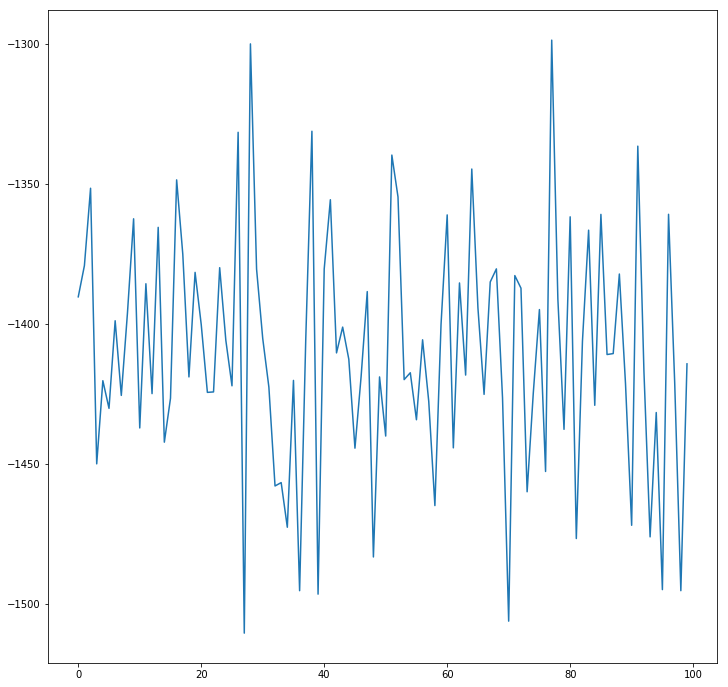

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,12))
plt.plot(range(len(results)), [x[0] for x in results]);